In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.metrics import AUC, Recall, Precision
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import tensorflow as tf

## Project and Data

This deep learning project utilizes data in the field of high-energy particle physics. The data was obtained from the University of California Irvine (UCI) machine learning repository, maintained by the Center for Machine Learning and Intelligent Systems. Here, we are examining data that was generated via Monte Carlo simulations (That is, random sampling of inputs are utilized to create a probabilistic system of the data involved. This data is set within reasons given the background knowledge of the topic. Thus, probabilistic data can be generated without having access to particle accelerators.) 

Particle accelerators, such as the Large Hadron Collider (LHC) collide particles together at near the speed of light to create high density particles. Baldi, Sadowski, and Whiteson note that accelerators such as the LHC can produce $10^{11}$ collisions hourly. Further, of these hundreds of billions of collisions, 300 or so generate in producing Higgs boson (a particle first discovered in 2012 by the LHC and the main scientific discovery to have occurred so far, from the accelerator). Due to the low probability of collisions resulting in Higgs bosons, it is crucial to classifier when a collision has resulted in the boson. To do this, data indicating background noise and true signals of the boson themselves need to be determined and used in the classification. The massive amounts of data generated from the collisions prove themselves as good candidates for deep learning to train on the data presented.

In the vein of large amounts of data from particle accelerators, this simulated dataset contains 11,000,000 instances of 28 features and a class associated with each of these instances. The 28 features are all numeric values and are of float64 type. The actual features themselves and their meaning as the particles at hand are vastly beyond my lay-person's knowledge of physics. However, in UCI's repository, they state that 21 of the 28 features are low-level features and that 7 are high-level. Further, the classes of the data are binary and are labeled as 0 and 1. 

In the paper itself, 500,000 instances are utilized as the test set and I will mirror this approach. 


Initial academic paper for data: https://arxiv.org/abs/1402.4735

Repository for the data: http://archive.ics.uci.edu/ml/datasets/HIGGS

Monte Carlo: https://news.mit.edu/2010/exp-monte-carlo-0517

Particle Accelerators: https://www.home.cern/science/accelerators/large-hadron-collider

In [2]:
#columns provided by UCI repository
columns = ['class', 'lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']
colnames = [i.replace(' ', '_') for i in columns]

In [3]:
#getting df from csv and changing column names
df = pd.read_csv('HIGGS.csv', names = colnames, header = None)
print(df.shape)

(11000000, 29)


## EDA

To begin, I got the column names for each feature and then changed the column initially provided to the correct column name. After that, I wanted to get an overall view of the data. Utilizing the info of the df, we see every data point is of float 64. Further, we also see the magnitude of this dataset as its memory usage is 2.4 GB which is high for numeric values, but expected given the number of instances. Then, I utilized the detail method of the df. With this, I was largely checking for outliers, but it also provides a quick picture of the mean, sd and other summary statistics. From this, I do not immediately see any outliers. Next, I looked to see if there were any na's in the dataframe and there were none present. 

Then, I wanted to check if the data was imbalanced among the two classes. We found that a majority of the data were of the class 1, but this imbalance was slight and thus, measures were not taken to remove it. After this, I wanted to visualize how the numerical data stacked up among its features. Thus, I utilized altair to create a chart of the median values for each median in the training and test set. Further, I added error bars on these medians which accounted for += 1.96 sd of the median. The chart was made interactive, so that one can hover their mouse over a feature and this will highlight that feature on both charts for training and test data. 

After this, I calculated correlations for all features in training and test sets and plotted these correlations as a heatmap with seaborn. In this, I set a threshold that the correlation must have an absolute value of $>=0.1$. From the heatmap, we can see we do not have a lot of correlation in the data with most values being quite below 0.5 and only a couple variables appear to be heavily correlated. 

Lastly, I created a histogram for each of the features and we see that our data is very non-normal (just with a visual test, statistical tests were not ran to test this) and that only a few columns appear normal. I was surprised at this given the large amount of instances.

In [4]:
df.info()
print('\n')
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000000 entries, 0 to 10999999
Data columns (total 29 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   class                     float64
 1   lepton_pT                 float64
 2   lepton_eta                float64
 3   lepton_phi                float64
 4   missing_energy_magnitude  float64
 5   missing_energy_phi        float64
 6   jet_1_pt                  float64
 7   jet_1_eta                 float64
 8   jet_1_phi                 float64
 9   jet_1_b-tag               float64
 10  jet_2_pt                  float64
 11  jet_2_eta                 float64
 12  jet_2_phi                 float64
 13  jet_2_b-tag               float64
 14  jet_3_pt                  float64
 15  jet_3_eta                 float64
 16  jet_3_phi                 float64
 17  jet_3_b-tag               float64
 18  jet_4_pt                  float64
 19  jet_4_eta                 float64
 20  jet_4_phi             

,class,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b-tag,...,jet_4_eta,jet_4_phi,jet_4_b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
count,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,...,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07
mean,5.299203e-01,9.914658e-01,-8.297618e-06,-1.327225e-05,9.985364e-01,2.613459e-05,9.909152e-01,-2.027520e-05,7.716199e-06,9.999687e-01,...,-5.756954e-06,1.744903e-05,1.000000e+00,1.034290e+00,1.024805e+00,1.050554e+00,1.009742e+00,9.729596e-01,1.033036e+00,9.598120e-01
std,4.991040e-01,5.653777e-01,1.008827e+00,1.006346e+00,6.000185e-01,1.006326e+00,4.749747e-01,1.009303e+00,1.005901e+00,1.027808e+00,...,1.007694e+00,1.006366e+00,1.400209e+00,6.746354e-01,3.808074e-01,1.645763e-01,3.974453e-01,5.254063e-01,3.652556e-01,3.133378e-01
min,0.000000e+00,2.746966e-01,-2.434976e+00,-1.742508e+00,2.370088e-04,-1.743944e+00,1.375024e-01,-2.969725e+00,-1.741237e+00,0.000000e+00,...,-2.497265e+00,-1.742691e+00,0.000000e+00,7.507046e-02,1.986757e-01,8.304866e-02,1.320062e-01,4.786215e-02,2.951122e-01,3.307214e-01
25%,0.000000e+00,5.907533e-01,-7.383225e-01,-8.719308e-01,5.768156e-01,-8.712081e-01,6.789927e-01,-6.872450e-01,-8.680962e-01,0.000000e+00,...,-7.141902e-01,-8.714789e-01,0.000000e+00,7.906095e-01,8.462266e-01,9.857525e-01,7.675732e-01,6.738168e-01,8.193964e-01,7.703901e-01
50%,1.000000e+00,8.533714e-01,-5.415563e-05,-2.410638e-04,8.916277e-01,2.125454e-04,8.948193e-01,-2.543566e-05,5.813991e-05,1.086538e+00,...,3.721330e-04,-2.642369e-04,0.000000e+00,8.949304e-01,9.506853e-01,9.897798e-01,9.165110e-01,8.733798e-01,9.473447e-01,8.719701e-01
75%,1.000000e+00,1.236226e+00,7.382142e-01,8.709940e-01,1.293056e+00,8.714708e-01,1.170740e+00,6.871941e-01,8.683126e-01,2.173076e+00,...,7.141017e-01,8.716055e-01,3.101961e+00,1.024730e+00,1.083493e+00,1.020528e+00,1.142226e+00,1.138439e+00,1.140458e+00,1.059248e+00
max,1.000000e+00,1.209891e+01,2.434868e+00,1.743236e+00,1.539682e+01,1.743257e+00,9.940391e+00,2.969674e+00,1.741454e+00,2.173076e+00,...,2.498009e+00,1.743372e+00,3.101961e+00,4.019237e+01,2.037278e+01,7.992739e+00,1.426244e+01,1.776285e+01,1.149652e+01,8.374498e+00


In [5]:
#splitting df into a training and test set with test set having 500,000 values
train, test = train_test_split(df, test_size = 500000/df.shape[0], random_state = 42)
print('Train: ', train.shape)
print('Test: ', test.shape)
print('\n')
#function to print the number of na values for each dataframe
def num_nulls(df):
    na = df.isna().sum().sum()
    if na == 0:
        return 'No null values'
    else:
        return na
print('Train:', num_nulls(train))
print('Test:', num_nulls(test))

Train:  (10500000, 29)
Test:  (500000, 29)


Train: No null values
Test: No null values


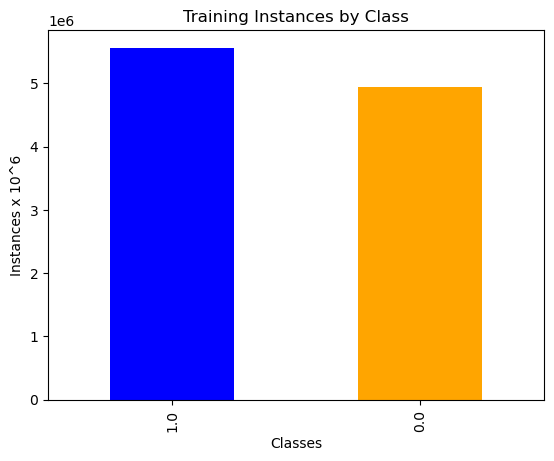

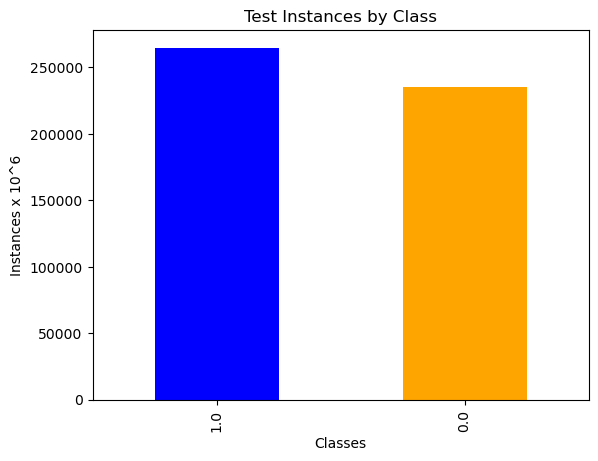

In [6]:
#Chart to show number of instances by class in training dataframe
train['class'].value_counts().plot(kind = 'bar', color = ['blue', 'orange'])
plt.title('Training Instances by Class')
plt.xlabel('Classes')
plt.ylabel('Instances x 10^6')
plt.show()
plt.clf()

#Chart to show number of instances by class in test dataframe
test['class'].value_counts().plot(kind = 'bar', color = ['blue', 'orange'])
plt.title('Test Instances by Class')
plt.xlabel('Classes')
plt.ylabel('Instances x 10^6')
plt.show()

In [7]:
#Getting column names of df's and setting as list
medians_cols = list(train.columns)
#getting the median values for each feature depending on the class target
one_medians = train[train['class'] == 1.0].median().values
one_medians = pd.Series(one_medians)
one_medians.index = medians_cols
zero_medians = train[train['class'] == 0].median().values
zero_medians = pd.Series(zero_medians)
zero_medians.index = medians_cols
#getting std values for each feature depending on the class target
ones_sd = np.std(train[train['class'] == 1])
zeros_sd = np.std(train[train['class'] == 0])


#creating four empty lists which will be filled with median values +- 1.96 std 
max_vals_one = []
min_vals_one = []
max_vals_zero = []
min_vals_zero = []

#function that utilizes standard deviation and median values and adds +- 1.96 std
def sd_3(sd, median, val, val_list):
    #meaning we want to add 1.96 sd
    if val == 'max':
        for i in range(sd.shape[0]):
            #add to appropriate list
            val_list.append(median.iloc[i] + (1.96 * sd.iloc[i]))
    #subtracting 1.96sd
    else:
        for i in range(sd.shape[0]):
            val_list.append(median.iloc[i] - (1.96 * sd.iloc[i]))
            
#running function four times so as to fill our four empty lists
sd_3(ones_sd, one_medians, 'max', max_vals_one)
sd_3(ones_sd, one_medians, 'min', min_vals_one)
sd_3(zeros_sd, zero_medians, 'max', max_vals_zero)
sd_3(zeros_sd, zero_medians, 'min', min_vals_zero);

#function to convert list to pd Series and to set the index to be the feature names of original dataset
def list_series(list):
    series = pd.Series(list)
    series.index = medians_cols
    return series
#running each of four lists into function to become series
max_vals_one = list_series(max_vals_one)
min_vals_one = list_series(min_vals_one)
max_vals_zero = list_series(max_vals_zero)
min_vals_zero = list_series(min_vals_zero);

#combining median values and max_min for each class into a single dataframe
df_format = pd.concat([one_medians, zero_medians, max_vals_one, min_vals_one, max_vals_zero, min_vals_zero], 
                      axis = 1)
#dropping the row for class since this provides no meaningful information
df_format = df_format.drop('class', axis=0)
#reset index and adding 'index' column for charting with altair
df_format = df_format.reset_index()
#renaming columns to descriptive title and to string for charting with altair
df_format = df_format.rename(columns = {
    0: 'one_median', 1: 'zero_median', 2: 'one_max', 3: 'one_min', 4: 'zero_max', 5: 'zero_min'
})

In [8]:
### Altair Chart

#adding selection so that when mouse hovers over value that value is selected
selection = alt.selection(type='multi', fields=['index'], on='mouseover', nearest=True)

#creating chart for all data associated with class of 1
ones = alt.Chart(df_format).mark_point(filled = True, size = 80).encode(
    alt.X('index:N', title = 'Features'),
    alt.Y('one_median:Q', title = 'Feature Measures'),
    #setting color scheme
    color = alt.Color('index', scale = alt.Scale(scheme = 'tableau20')),
    #setting option so that data not selected on mouseover becomes more transparent
    opacity=alt.condition(selection, alt.value(1), alt.value(.2)),
    #when selecting data point, tooltip shows values associated each col
    tooltip = ['index', 'one_median', 'one_max', 'one_min']
).interactive().properties(height = 200, title = 'Features for Class One').add_selection(selection)

#creating error bars for 1.96 sd +- median value
error_bars = ones.mark_errorbar(size = 80).encode(
    x = 'index',
    y = 'one_max:Q',
    y2 = 'one_min:Q'
)

#utilizing the same mechanism as above, but this time utilizing for values of class 0
zero = alt.Chart(df_format).mark_point(filled = True, size = 80).encode(
    alt.X('index:N', title = 'Features'),
    alt.Y('one_median:Q', title = 'Feature Measures'),
    color = alt.Color('index', scale = alt.Scale(scheme = 'tableau20')),
    opacity=alt.condition(selection, alt.value(1), alt.value(.2)),  
    tooltip = ['index', 'zero_median', 'zero_max', 'zero_min']
).interactive().properties(height = 200, title = 'Features for Class Zero').add_selection(selection)

error_bars_zero = zero.mark_errorbar(size = 80).encode(
    x = 'index',
    y = 'zero_max:Q',
    y2 = 'zero_min:Q'
)

#plotting each chart with its error bars charts stacked, so that they can be viewed concurrently
charts = (ones + error_bars) & (zero + error_bars_zero)
charts

alt.VConcatChart(...)

In [9]:
## Correlations above the threshold of 0.1 postivie or negative 
cor_mat = train.corr()
threshold = 0.1
filtered_cor_mat = cor_mat[abs(cor_mat) >= threshold]
#adding a mask so that only bottom half of sns heatmap shows
mask = np.triu(np.ones_like(filtered_cor_mat, dtype=bool))

#correlations above threshold for test data
cor_mat_test = test.corr()
filtered_cor_mat_test = cor_mat_test[abs(cor_mat_test) >= threshold]
#adding same type of mask, but for tst data here
mask = np.triu(np.ones_like(filtered_cor_mat_test, dtype=bool))

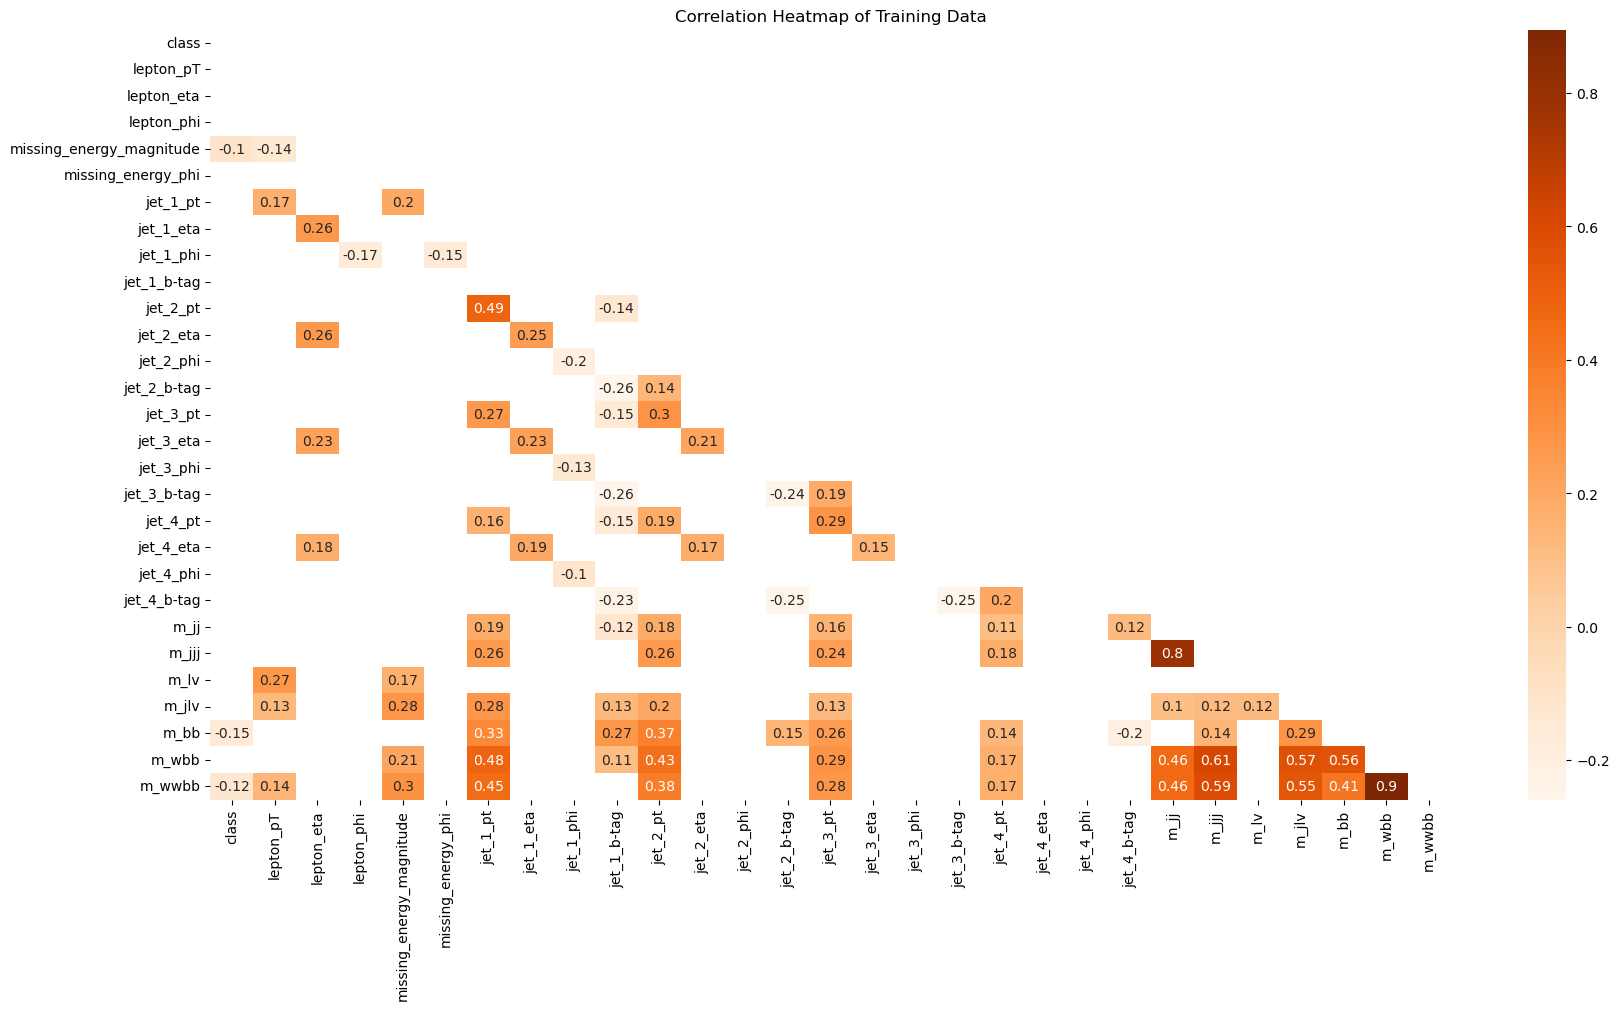

In [10]:
#plotting correlations with sns, showing the corrs above threshold of abs(0.1)
plt.figure(figsize=(20,10))
sns.heatmap(filtered_cor_mat, annot=True, cmap="Oranges", mask = mask)
plt.title('Correlation Heatmap of Training Data')
plt.show()

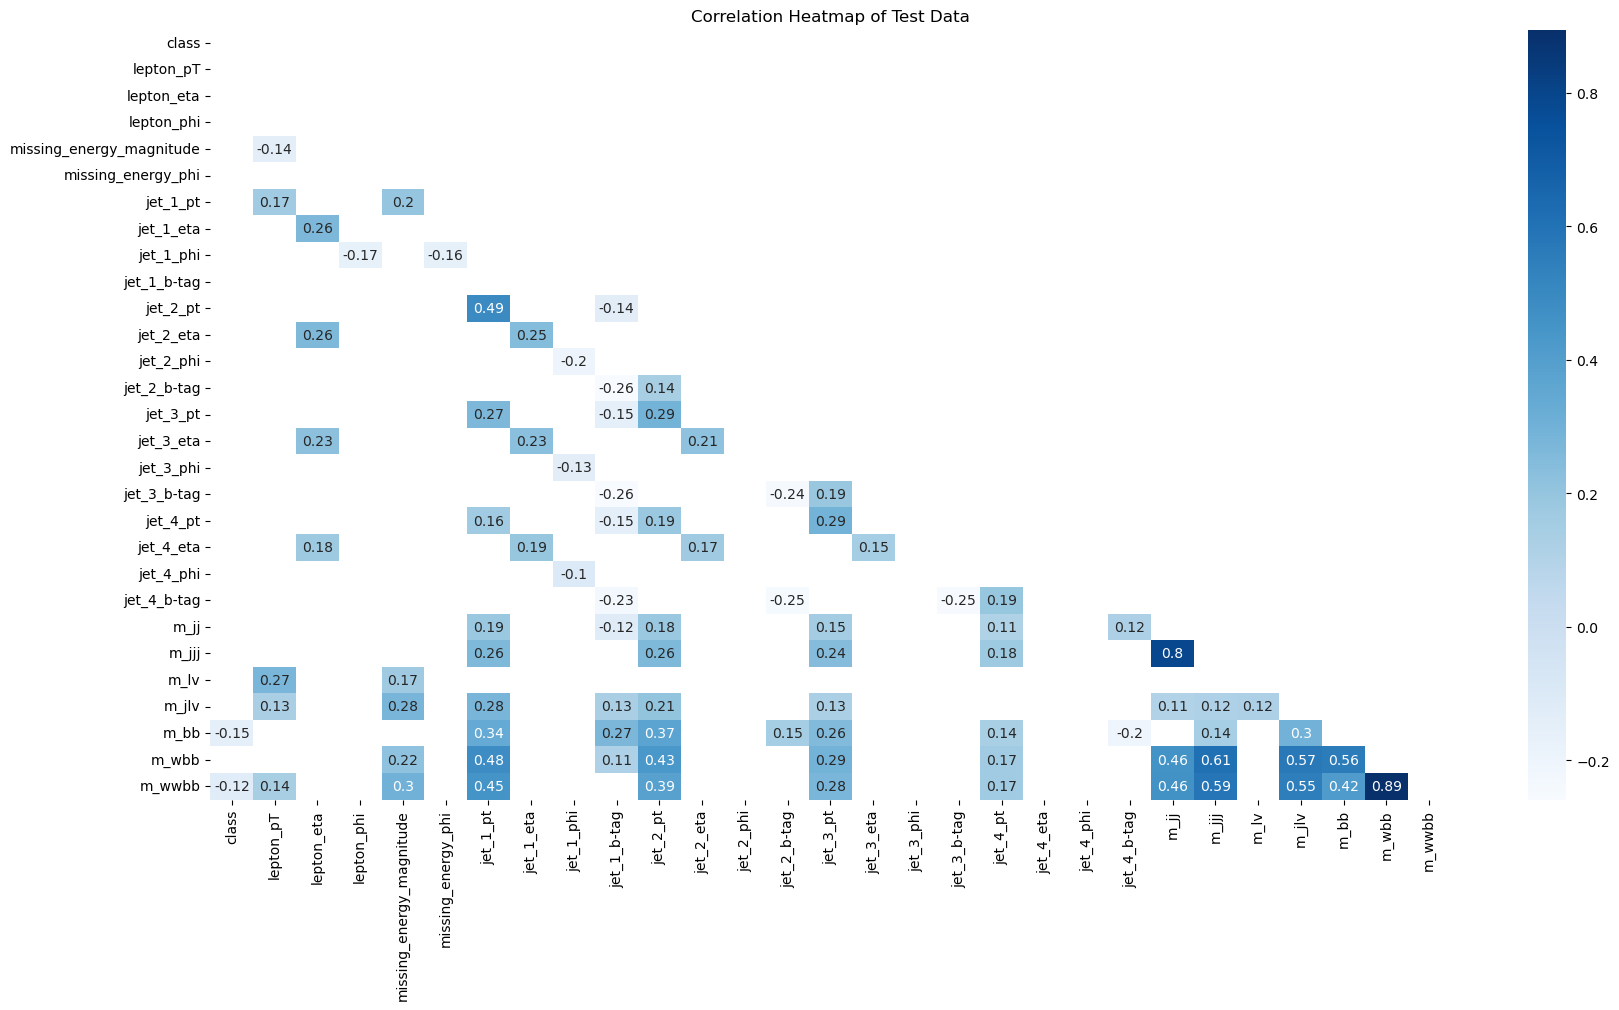

In [11]:
#correlation heat map for test data plot
plt.figure(figsize = (20,10))
sns.heatmap(filtered_cor_mat_test, annot=True, cmap='Blues', mask = mask)
plt.title('Correlation Heatmap of Test Data')
plt.show()

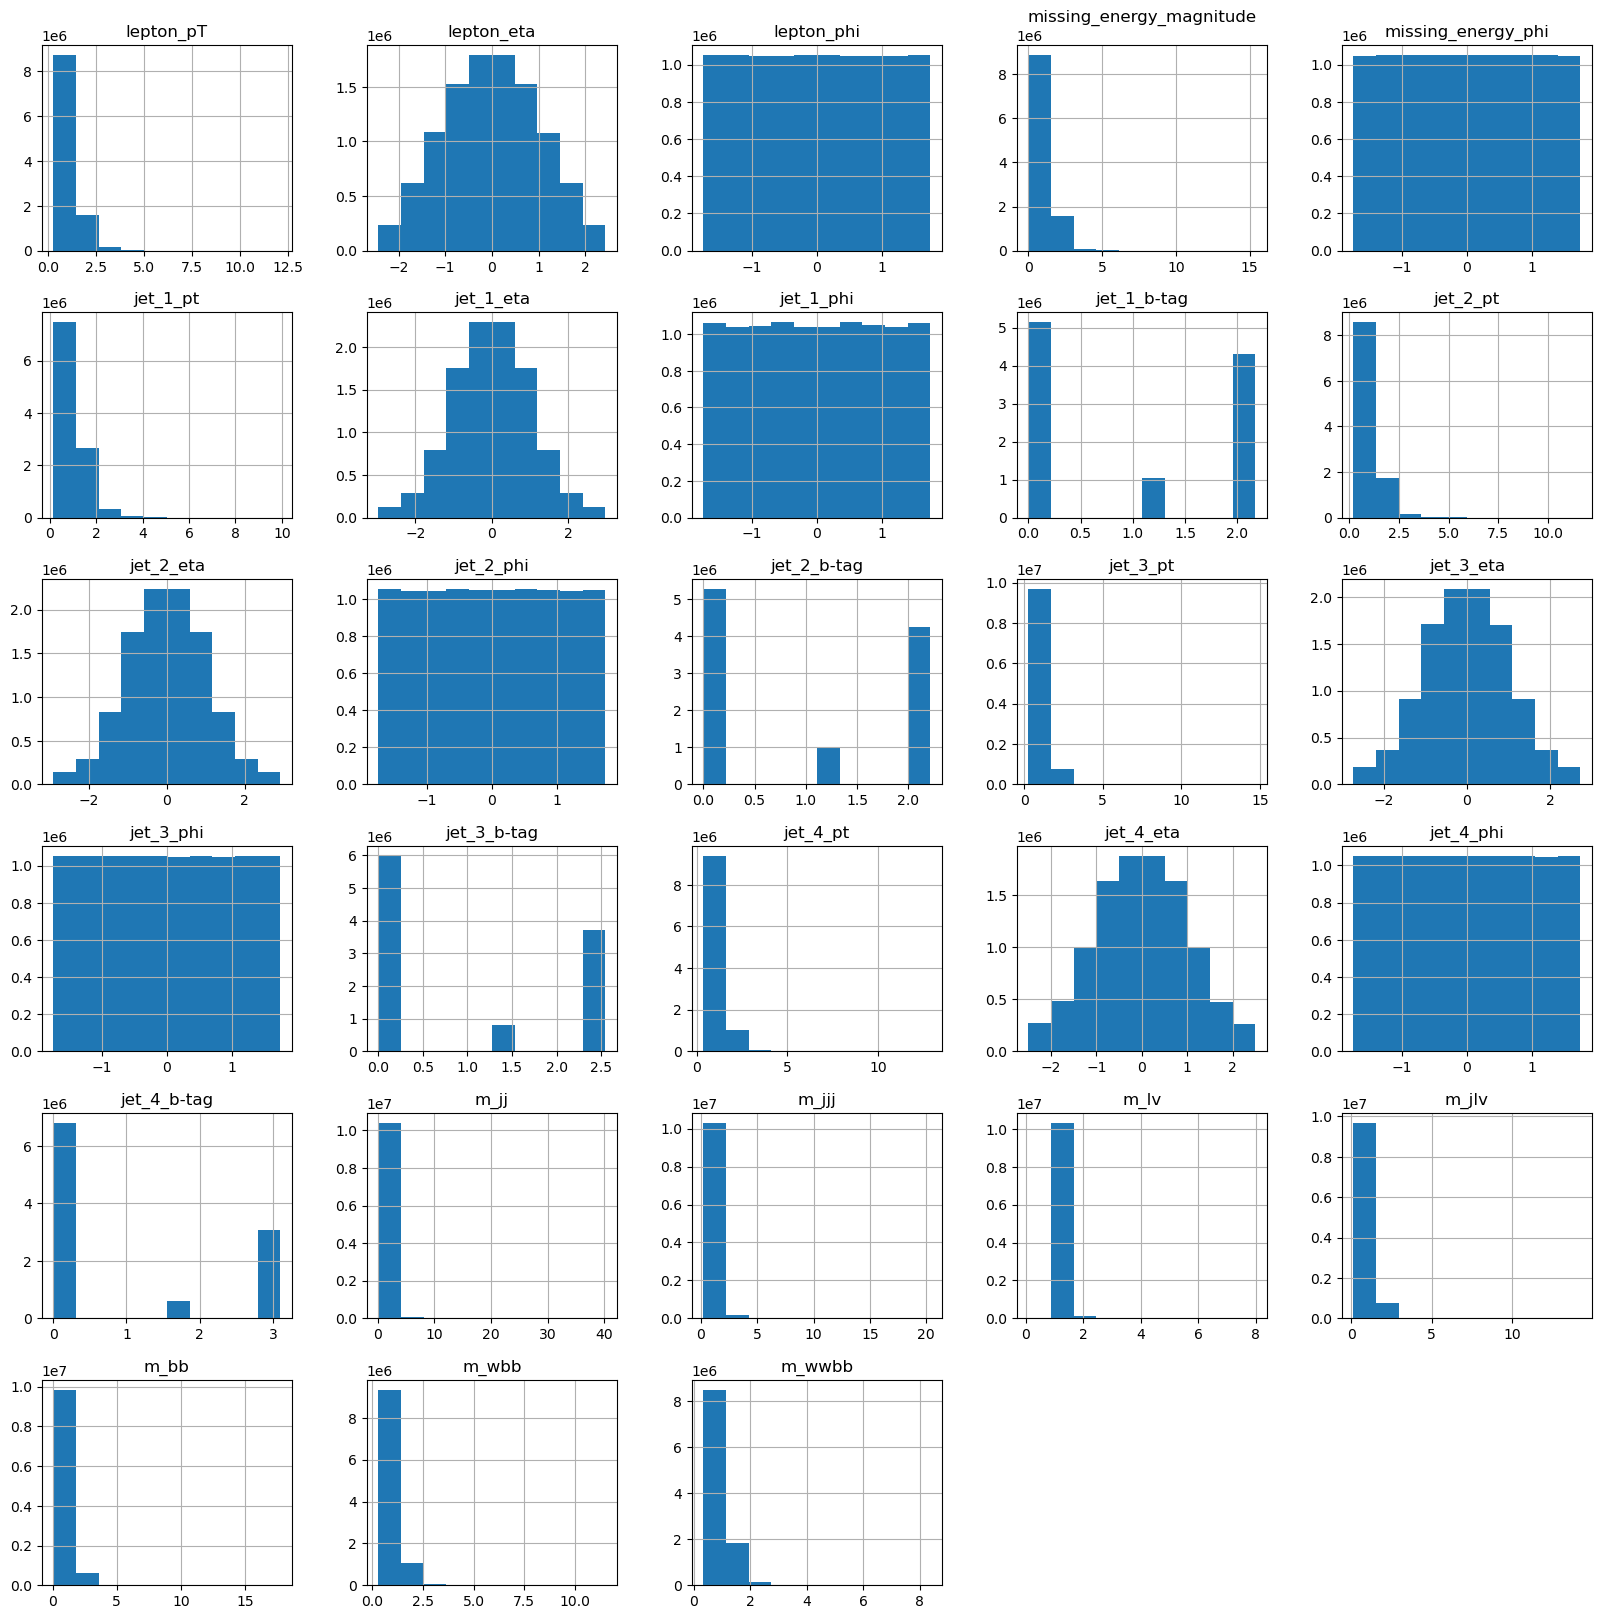

In [12]:
##histogram
train.drop('class', axis = 1).hist(figsize=(20, 20))
plt.show()

## Preprocessing

Due to the large number of instances of the data and the fact I am using my personal Macbook Air, I sought to improve model efficiency. 

I first intended to do this by scaling the data with sklearn's MinMaxScaler. This normalizes the data by placing all values in a range of $[0-1]$. This is achieved by taking each value $x$ for a feature and:
$\frac{x - x_{min}} {x_{max} - x_{min}}$. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*This proved to be a mistake in my logic. While I was aware normalized data is not required for neural network. I was surprised to find my test accuracy &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;dipped much lower than training and validation accuracy. This occurred when I applies the same normalization to the test data. When this was done, &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;training and validation accuracy was ~0.78 and test accuracy was ~0.65. This type of drop off was not found in my training models when data was not &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;normalized. Hence, I chose to bypass normalization.*

Additionally, I converted dataframe into a TensorFlow dataset. Doing this allowed me to better utilize the limited GPU I have at my disposal. This allows the next iterations of the dataset (i.e. shuffling for each iteration) to begin work while the current iteration of the dataset is being created (achieved through the use of dataset.prefetch). Additionally, when creating my datasets, I transferred the float values from float64 to float32. By switching from 64 to 32 bits per data point, the memory is vastly improved in my model's speed performance. I anticipated a decrease in model performance; however, when training on both float64 and float32, there was only a marginal difference in accuracy. Then, with my dataset, I got batches of it in size 10,000 and the dataset was then shuffled through each iteration of the model. I also set a cache for the elements of the dataset. This means that in the first iteration, the elements of dataset will be saved to a cache and these elements will drawn from the cache in each subsequent epoch. Again, this is a method for improving model efficiency.

Lastly, I split the batched dataset into training and validation datasets which were 0.8 and 0.2 of the initial dataset size, respectively.




Sources: 

https://www.educative.io/answers/standardization-vs-min-max-normalization

https://ui.adsabs.harvard.edu/abs/2012arXiv1203.3838C/abstract

https://www.tensorflow.org/guide/data_performance

https://medium.com/when-i-work-data/converting-a-pandas-dataframe-into-a-tensorflow-dataset-752f3783c168

In [18]:
#standardizing data for improved model performance
# scaler = MinMaxScaler()
# train_scale = pd.DataFrame(scaler.fit_transform(train.drop('class', axis = 1)))
# test_scale = pd.DataFrame(scaler.fit_transform(test.drop('class', axis = 1)))


#creating tensorflow dataset as input to model
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        #casting values of df as float32 from float64 to half the memory
        tf.cast(train.drop(['class'], axis =1).values, tf.float32),
        #casting values of target as int32 from int64 to half memory
        tf.cast(train['class'], tf.int32)
    )
)
#batching the dataset with size 10000
batched_dataset = train_dataset.batch(10000)
#shuffling the batched dataset and reshuffling each iteration
batched_dataset = batched_dataset.shuffle(buffer_size = 200000, reshuffle_each_iteration=True)
#utilizing cache memory on dataset
batched_dataset = batched_dataset.cache()
#crucially doing this! so that data loads in parallel while model is running
batched_dataset = batched_dataset.prefetch(1000)

#taking 80% of dataset as training and 25% for validation
train_in = batched_dataset.take(int(len(batched_dataset) * 0.8))
valid_in = batched_dataset.skip(int(len(batched_dataset) * 0.8)).take(int(len(batched_dataset) * 0.2))
#source for help here https://medium.com/when-i-work-data/converting-a-pandas-dataframe-into-a-tensorflow-dataset-752f3783c168

## Modeling

Given the type of data I was working with, I knew I would largely be working with Keras Dense layers and a single output layer. However, there was still much to determine in terms of model architecture. Firstly, in the academic paper, I saw they conducted their model architecture with a tanh activation on all hidden layers. I was surprised at this and I initially did not follow their own decision. Thus, I began by using relu as the activation function on all my hidden layers as that is my standard choice. However, after a few iterations of my model I decided to follow the author's methodology and I too found it to optimize training accuracy. Lastly, in terms of activation function, I utilized tanh as my output function. Traditionally, I have utilized sigmoid as my output for binary classification; however, I chose to utilize tanh here given the fact that we do have negative data values and I thought tanh may help given its range of -1 to 1. Then, for the model architecture, I ran quite a few iterations to determine the number of layers needed. This is one of the largest, if not the largest dataset I have worked with; hence, I was unsure how complex the model needed to be to avoid any potential overfitting, but still have enough to learn and train. Eventually, I settle on 14 hidden layers and an output layer (with also an input layer). There was no theoretical explanation for this final number, but simply trial and error until I eventually was consistently getting an accuracy I deemed acceptable. 

Then, in terms of compiling the model, I utilized the Adam optimizer with an initial learning rate of 0.001. However, learning rate scheduler was utilized and after the first epoch, the learning rate was decreased exponentially each subsequent epoch (to provide more in depth learning and slower weight updates as the model continues to run). Then, the loss of the model was measured in binary crossentropy, given this was a binary classification problem. Lastly, the metrics the model was compiled on were accuracy, area under the ROC curve and recall. I chose to add other metrics given the desire to avoid false negatives in the product, but I also typically utilize other metrics besides accuracy for a more robust model. Area under the ROC curve looks at the area under the curve when plotted on the true positive and false positive rate of the data, with the desired AUC to be as close to 1 as possible. Additionally, recall is a measure of the true positive rate and the false negative rate and this value should also be as close to possible to 1.

After the model was compiled, it needed to be fitted to the training data. This was done with the training data being analyzed with a batch size of 1000 (another number derived through trial and error). Then, early stopping was created with a patience of 1. That is there must be one full epoch of no decreasing loss before stopping. Additionally, my final number of epochs was 45. The authors of the initial paper utilized 200 plus epochs, but my computer did not allow for this thorough of a computation. Further, my early stopping tended to stop the model at the end of the 30's epochs or in the early 40's, so I am not sure if my model as it was created would benefit from more epochs. After the model completed its fitting, the training and validation accuracy were charted on a plot and the training and validation loss were also charted on their own plot. This helps to serve as a visual indicator of the model's performance throughout the epochs.

In [25]:
batch_size = 1000

#Building model itself and its layers
model = Sequential([
    Dense(512, activation = 'tanh', input_shape = (28,)),
    Dense(512, activation = 'tanh'),
    Dense(256, activation = 'tanh'),
    Dense(256, activation='tanh'),
    Dense(256, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(128, activation = 'tanh'),
    Dense(128, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(32, activation = 'tanh'),
    Dense(32, activation = 'tanh'),
    Dense(16, activation='tanh'),
    Dense(8, activation='tanh'),
    Dense(1, activation = 'tanh')
])
# model.summary()

#utilizing Adam optimizer with init l_r of 0.001 and amsgrad(to help with convergence)
opt = Adam(
    learning_rate = 0.001
)

#utilizing area under roc curve for additional metric
A_ROC = AUC()

#utilizing recall to reduce false negatives given low nature of higgs 
recall = Recall()



model.compile(optimizer = opt, loss='binary_crossentropy', metrics=['accuracy', A_ROC, recall])

Epoch 1/45


2023-02-27 23:10:02.915308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


839/840 [============================>.] - ETA: 0s - loss: 0.6320 - accuracy: 0.6337 - auc_5: 0.6900 - recall_5: 0.7626

2023-02-27 23:10:33.726351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


840/840 [==============================] - 35s 41ms/step - loss: 0.6319 - accuracy: 0.6338 - auc_5: 0.6901 - recall_5: 0.7625 - val_loss: 0.5766 - val_accuracy: 0.6953 - val_auc_5: 0.7681 - val_recall_5: 0.7741 - lr: 0.0010
Epoch 2/45
840/840 [==============================] - 33s 39ms/step - loss: 0.5497 - accuracy: 0.7158 - auc_5: 0.7907 - recall_5: 0.7395 - val_loss: 0.5228 - val_accuracy: 0.7351 - val_auc_5: 0.8156 - val_recall_5: 0.7845 - lr: 9.0484e-04
Epoch 3/45
840/840 [==============================] - 33s 39ms/step - loss: 0.5410 - accuracy: 0.7217 - auc_5: 0.7985 - recall_5: 0.7490 - val_loss: 0.5101 - val_accuracy: 0.7444 - val_auc_5: 0.8254 - val_recall_5: 0.7640 - lr: 8.1873e-04
Epoch 4/45
840/840 [==============================] - 35s 41ms/step - loss: 0.5402 - accuracy: 0.7205 - auc_5: 0.7986 - recall_5: 0.7610 - val_loss: 0.5034 - val_accuracy: 0.7483 - val_auc_5: 0.8305 - val_recall_5: 0.7881 - lr: 7.4082e-04
Epoch 5/45
840/840 [==============================] - 42s 5

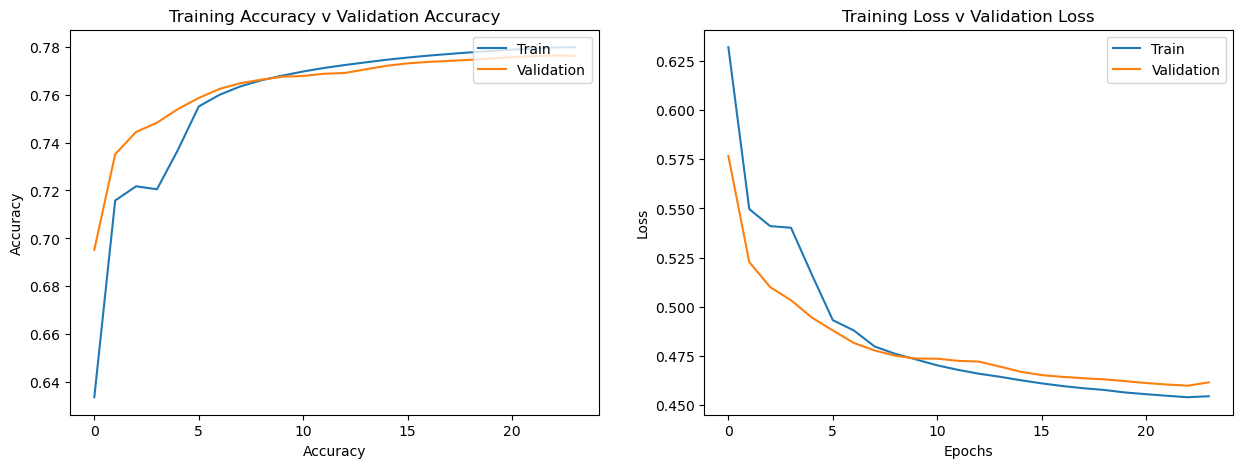

In [26]:
#setting up an early stopping callback, to stop running when no longer improving
early = EarlyStopping(patience = 1)

#learning rate scheduler for increased model performance
#schedule has it so that learning rate decreases exponentially after the 2nd epoch
def scheduler(epoch, lr):
    if epoch < 1:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

#callback to run learning rate scheduler
learning = LearningRateScheduler(scheduler)


history = model.fit(
    train_in,
    validation_data = valid_in,
    epochs = 45, 
    batch_size = batch_size,
    callbacks=[early, learning]
)

#chart for accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
#accuracy chart
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Training Accuracy v Validation Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc ='upper right')
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Training Loss v Validation Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

## Predictions and Results

To get my predictions, I take the trained model and predict it on the test dataframe I created in the beginning. Then, for each value in predictions, if prediction is $>=0.5$, then a 1 is predicted and else a 0 is predicted. Next, I calculated accuracy, recall, precision and f1 score through sklearn packages and these values were printed. 

In [27]:
predictions = model.predict(test.drop('class', axis=1), verbose = 0)
predictions_final = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
accuracy = accuracy_score(test['class'], predictions_final)
recall = recall_score(test['class'], predictions_final)
precision = precision_score(test['class'], predictions_final)
f1 = f1_score(test['class'], predictions_final)
print('accuracy: ', accuracy)
print('recall: ', recall)
print('precision: ', precision)
print('f1 score: ', f1)

2023-02-27 23:28:21.244024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


accuracy:  0.777086
recall:  0.8091923214858717
precision:  0.7787106196233434
f1 score:  0.7936589041374855


## Conclusion

In conclusion, this project looked at simulated data of a particle accelerator. Its objective was to build a classifier which could identify when Higgs bosons were produced from the collisions formed in the accelerator or not. Accelerators such as Large Hadron from CERN can perform $10^[11]$ collisions in an hour with only approximately 300 producing bosons. Thus, given the low probability of occurrences an adequate classifier is vastly needed.

The data provided by the UCI Machine Learning repository included 11,000,000 instances of 28 features and a target class. Exploratory data analysis was performed, with included data visualizations, data was preprocessed utilizing a tensorflow dataset which vastly improved speed of modeling, and a Keras sequential model was built and trained on a split of the train/test split of the data, the the model was used to classify the test split of the initial data and metrics of accuracy, recall, precision, and f1 score were measured.

The results from the finalized product were:

Accuracy: 0.777
Recall: 0.809
Precision: 0.779
F1 Score: 0.794


Github repo: https://github.com/skembr01/Higgs_NN_Classifier